<a href="https://colab.research.google.com/github/TorbjornLarsson/SMI/blob/main/exercises/SML-session_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bias-variance trade-off, model selection and cross validation – Computer exercises

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import sklearn.preprocessing as skl_pre
import sklearn.linear_model as skl_lm
import sklearn.discriminant_analysis as skl_da
import sklearn.neighbors as skl_nb
import sklearn.model_selection as skl_ms

## 6.1 Cross validation in $k$-NN
In this exercise we will return to the `biopsy` data set also used in Exercise 4.1 (Lesson 4). We will try to determine suitable value of $k$ in $k$-NN for this data. For simplicity, we will only consider the three attributes in columns `V3`, `V4`and `V5` in this problem.

### (a)
Consider all data as training data. Investigate how the training error varies with different values of $k$ (hint: use a `for`-loop). Which $k$ gives the best result? Is it a good choice of $k$?

In [2]:
# Load the data
# url = 'data/biopsy.csv'
url = 'https://uu-sml.github.io/course-sml-public/data/biopsy.csv'
biopsy = pd.read_csv(url, dtype={'ID': str}).dropna().reset_index(drop=True)

In [11]:
biopsy[:10]

,ID,V1,V2,V3,V4,V5,V6,V7,V8,V9,class
0,1000025,5,1,1,1,2,1.0,3,1,1,benign
1,1002945,5,4,4,5,7,10.0,3,2,1,benign
2,1015425,3,1,1,1,2,2.0,3,1,1,benign
3,1016277,6,8,8,1,3,4.0,3,7,1,benign
4,1017023,4,1,1,3,2,1.0,3,1,1,benign
5,1017122,8,10,10,8,7,10.0,9,7,1,malignant
6,1018099,1,1,1,1,2,10.0,3,1,1,benign
7,1018561,2,1,2,1,2,1.0,3,1,1,benign
8,1033078,2,1,1,1,2,1.0,1,1,5,benign
9,1033078,4,2,1,1,2,1.0,2,1,1,benign


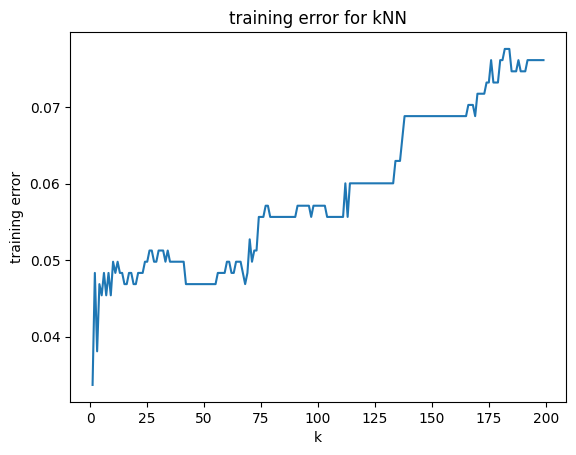

In [3]:
np.random.seed(1)
X = biopsy[['V3', 'V4', 'V5']]
y = biopsy['class']
misclassification = []
K = np.arange(1,200)
for k in K: # Try n_neighbors = 1, 2, ...., 199
 model = skl_nb.KNeighborsClassifier(n_neighbors=k)
 model.fit(X, y)
 prediction = model.predict(X)
 misclassification.append(np.mean(prediction != y))
plt.plot(K, misclassification)
plt.title('training error for kNN')
plt.xlabel('k')
plt.ylabel('training error')
plt.show()
#k = 1 has the best performance. That is, however, expected and is not a good
# measure of which $k$ should be used.

### (b) <a id='6.1-b'></a>
Split the data randomly into a training and validation set, and see how well you perform on the validation set. (Previously, we have used the terminology "training" and "test" set. If the other set (not the training set) is used to make design decisions, such as choosing $k$, it is really not a test set, but rather a "validation" set. Hence the
terminology.) Which $k$ gives the best result?

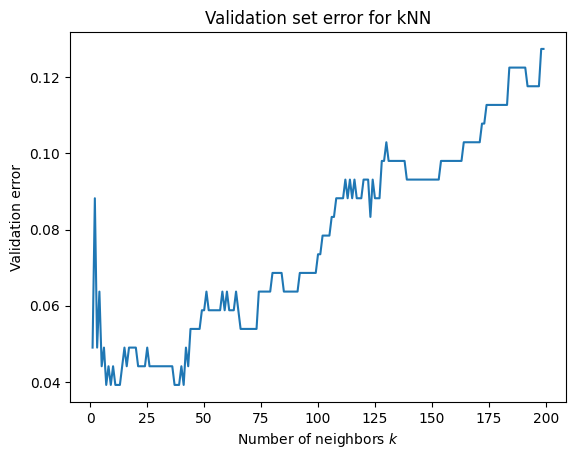

In [4]:
np.random.seed(1)
N = len(X)
M = np.ceil(0.7*N).astype(int) # Number of training data
idx = np.random.permutation(N)
X_train, X_val = X.iloc[idx[:M]], X.iloc[idx[M:]]
y_train, y_val = y.iloc[idx[:M]], y.iloc[idx[M:]]
# Or use scikit learn
# X_train, X_val, y_train, y_val = skl_ms.train_test_split(X, y, test_size=
# 0.3, random_state=1)
misclassification = []
K = np.arange(1,200) # Try n_neighbors = 1, 2, ...., 199
for k in K:
 model = skl_nb.KNeighborsClassifier(n_neighbors=k)
 model.fit(X_train, y_train)
 prediction = model.predict(X_val)
 misclassification.append(np.mean(prediction != y_val))
plt.plot(K, misclassification)
plt.title('Validation set error for kNN')
plt.xlabel('Number of neighbors $k$')
plt.ylabel('Validation error')
plt.show()
# $k$ between 5-50 seems good, but the
# result seems noisy and hard to interpret

### (c)
Perform [(b)](#6.1-b) 10 times for different validation sets and average the result. Which $k$ gives the best result?

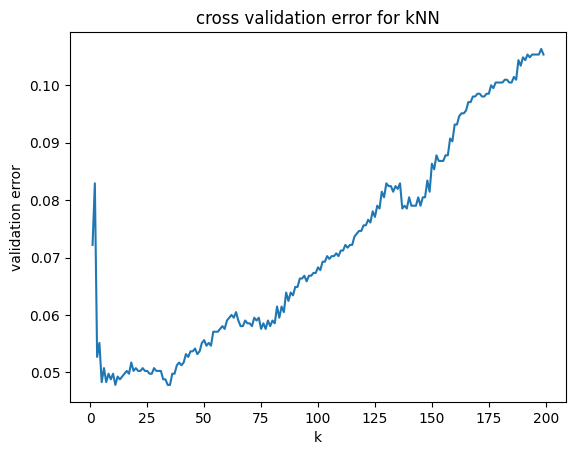

In [7]:
n_runs = 10
K = np.arange(1,200)
misclassification = np.zeros((n_runs, len(K)))
for i in range(n_runs):
 X_train, X_val, y_train, y_val = skl_ms.train_test_split(X, y, test_size=0.3)
 for j, k in enumerate(K):
  model = skl_nb.KNeighborsClassifier(n_neighbors=k)
  model.fit(X_train, y_train)
  prediction = model.predict(X_val)
  misclassification[i, j] = (np.mean(prediction != y_val))

average_mis = np.mean(misclassification, axis=0)
plt.plot(K, average_mis)
plt.title('cross validation error for kNN')
plt.xlabel('k')
plt.ylabel('validation error')
plt.show()
# The result shows that k between 5 and 35 perfom the best.

### (d)
Perform 10-fold cross-validation by first randomly permute the data set, divide the data set into 10 equally sized parts and loop through them by taking one part as validation set and the rest as training set each time. Which $k$ gives the best result?

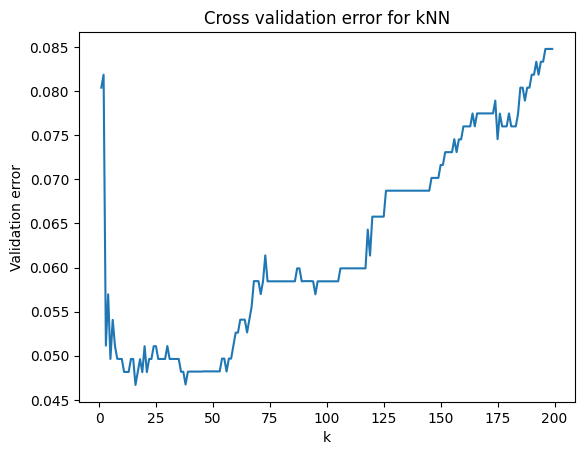

In [10]:
# Using Scikit learn KFold
n_fold = 10
cv = skl_ms.KFold(n_splits=n_fold, random_state=2, shuffle=True)
K = np.arange(1,200)
misclassification = np.zeros(len(K))
for train_index, val_index in cv.split(X):
 X_train, X_val = X.iloc[train_index], X.iloc[val_index]
 y_train, y_val = y.iloc[train_index], y.iloc[val_index]

 for j, k in enumerate(K):
  model = skl_nb.KNeighborsClassifier(n_neighbors=k)
  model.fit(X_train, y_train)
  prediction = model.predict(X_val)
  misclassification[j] += np.mean(prediction != y_val)
misclassification /= n_fold
plt.plot(K, misclassification)
plt.title('Cross validation error for kNN')
plt.xlabel('k')
plt.ylabel('Validation error')
plt.show()
# The result shows that k between 5 and 60 perfom the best


## 6.2 Cross validation for model choice

In this problem we will consider the data sets `data/pima_tr.csv` and `data/pima_te.csv`. Your task is to do as good prediction as possible for the test set `pima_te`, but you are only allowed to look at the true output in `pima_te` once (like in the real life, where you design and implement a method, and then hand it over to the ultimate test, namely the user). Hence, you will have to use `pima_tr` for both deciding which model to use and training the model.

The data set describes the prevalence of diabetes in women at least 21 years old of Pima Indian heritage, living near Phoenix, Arizona, USA. The data set describes, for each individual, whether she has diabetes or not, her age, the diabetes pedigree function (a summary of the diabetes history in her family), BMI, skin thickness, blood pressure, plasma glucose concentration and number of pregnancies.

The data frame contains the following columns:  
`npreg` number of pregnancies.  
`glu` plasma glucose concentration in an oral glucose tolerance test.  
`bp` diastolic blood pressure (mm Hg).  
`skin` triceps skin fold thickness (mm).  
`bmi` body mass index (weight in kg/(height in m)\^2).  
`ped` diabetes pedigree function.  
`age` age in years.  
`type` Yes or No, for diabetic according to WHO criteria.


### (a)
Load the library and familiarize yourself with `pima_tr`

In [9]:
# Load the datasets
# url = 'data/pima_tr.csv'
url = 'https://uu-sml.github.io/course-sml-public/data/pima_tr.csv'
pima_tr = pd.read_csv(url)

# url = 'data/pima_tr.csv'
url = 'https://uu-sml.github.io/course-sml-public/data/pima_te.csv'
pima_te = pd.read_csv(url)

In [12]:
pima_tr.describe()

,npreg,glu,bp,skin,bmi,ped,age
count,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000
mean,3.570000,123.970000,71.260000,29.215000,32.310000,0.460765,32.110000
std,3.366268,31.667225,11.479604,11.724594,6.130212,0.307225,10.975436
min,0.000000,56.000000,38.000000,7.000000,18.200000,0.085000,21.000000
25%,1.000000,100.000000,64.000000,20.750000,27.575000,0.253500,23.000000
50%,2.000000,120.500000,70.000000,29.000000,32.800000,0.372500,28.000000
75%,6.000000,144.000000,78.000000,36.000000,36.500000,0.616000,39.250000
max,14.000000,199.000000,110.000000,99.000000,47.900000,2.288000,63.000000


### (b)
See how well you can fit the `pima_tr` with logistic regression, LDA, QDA and k-NN (k = 2). The output is whether an individual has diabetes or not, and the input the remaining variables. What error rate does each method have? Is it a good indicator of which method is preferable?

In [13]:
X = pima_tr.drop(columns=['type'])
y = pima_tr['type']
# logistic regression
model = skl_lm.LogisticRegression(solver='liblinear')
model.fit(X, y)
prediction = model.predict(X)
err = np.mean(prediction != y)
print('Error rate for logistic regression: ' + str(err))
# LDA
model = skl_da.LinearDiscriminantAnalysis()
model.fit(X, y)
prediction = model.predict(X)
err = np.mean(prediction != y)
print('Error rate for LDA: ' + str(err))
# QDA
model = skl_da.QuadraticDiscriminantAnalysis()
model.fit(X, y)
prediction = model.predict(X)
err = np.mean(prediction != y)
print('Error rate for QDA: ' + str(err))
model = skl_nb.KNeighborsClassifier(n_neighbors=2)
model.fit(X, y)
prediction = model.predict(X)
err = np.mean(prediction != y)
print('Error rate for kNN: ' + str(err))


Error rate for logistic regression: 0.245
Error rate for LDA: 0.23
Error rate for QDA: 0.23
Error rate for kNN: 0.15


### (c)
Instead of [(b)](#6.2-b), perform 10-fold cross-validation by first randomly permute `pima_tr` and divide it in 10 parts. Then, in a loop with one of the 10 parts held out as validation data, fit logistic regression, LDA, QDA and k-NN (k = 2) to the training data and evaluate the performance on the validation data. Plot your results in a box plot with the error rates. Feel free to play around with the choice of inputs and other settings to improve the performance. Which method does this suggest us to use?

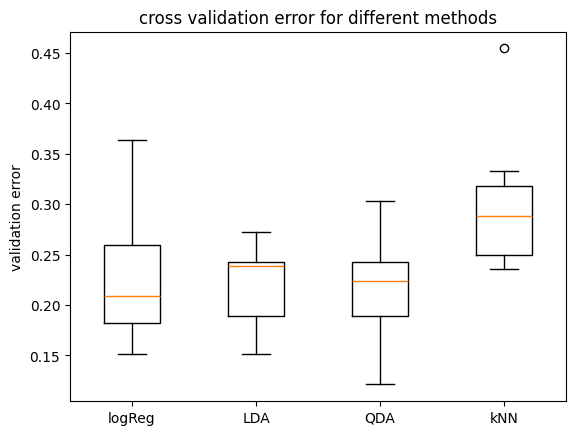

In [19]:
n_fold = 10
models = []
models.append(skl_lm.LogisticRegression(solver='liblinear'))
models.append(skl_da.LinearDiscriminantAnalysis())
models.append(skl_da.QuadraticDiscriminantAnalysis())
models.append(skl_nb.KNeighborsClassifier(n_neighbors=2))
misclassification = np.zeros((n_fold, len(models)))
cv = skl_ms.KFold(n_splits=n_fold, random_state=1, shuffle=True)
for i, (train_index, val_index) in enumerate(cv.split(X)):
 X_train, X_val = X.iloc[train_index], X.iloc[val_index]
 y_train, y_val = y.iloc[train_index], y.iloc[val_index]

 for m in range(np.shape(models)[0]): # try different models
  model = models[m]
  model.fit(X_train, y_train)
  prediction = model.predict(X_val)
  misclassification[i, m] = np.mean(prediction != y_val)
plt.boxplot(misclassification)
plt.title('cross validation error for different methods')
plt.xticks(np.arange(4)+1, ('logReg', 'LDA', 'QDA', 'kNN'))
plt.ylabel('validation error')
plt.show()


### d) <a id='6.4-d'/>
Now, decide which method to choose and train it on the entire data set `pima_tr` and predict `pima_te`. How well do you perform?

Error rate for LDA: 0.21385542168674698


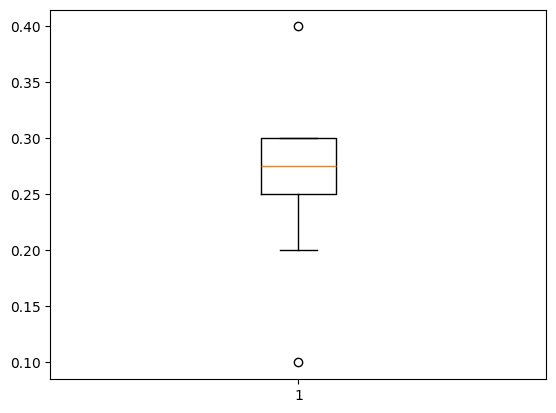

In [15]:
n_fold = 10
models = []
#models.append(skl_lm.LogisticRegression(solver='liblinear'))
models.append(skl_da.LinearDiscriminantAnalysis())
#models.append(skl_da.QuadraticDiscriminantAnalysis())
#models.append(skl_nb.KNeighborsClassifier(n_neighbors=2))
misclassification = np.zeros((n_fold, len(models)))
cv = skl_ms.KFold(n_splits=n_fold, random_state=1, shuffle=True)
for i, (train_index, val_index) in enumerate(cv.split(X)):
 X_train, X_val = X.iloc[train_index], X.iloc[val_index]
 y_train, y_val = y.iloc[train_index], y.iloc[val_index]

 for m in range(np.shape(models)[0]): # try different models
  model = models[m]
  model.fit(X_train, y_train)
  prediction = model.predict(X_val)
  misclassification[i, m] = np.mean(prediction != y_val)
plt.boxplot(misclassification)

X = pima_te.drop(columns=['type'])
y = pima_te['type']
# LDA
model.fit(X, y)
prediction = model.predict(X)
err = np.mean(prediction != y)
print('Error rate for LDA: ' + str(err))

### (e)
Now, since we are in a simulated environment, we can cheat and break the rule that we were only allowed to look at the true output in `pima_te` once. That is, explore how well the other methods do when you train them on `pima_tr` and predict `pima_te`. Did you make the "right" choice in [(d)](#6.4-d)?

In [20]:
X_test = pima_te.drop(columns=['type'])
y_test = pima_te['type']
# Logistic regression
model = skl_lm.LogisticRegression(solver='liblinear')
model.fit(X, y)
prediction = model.predict(X_test)
err = np.mean(prediction != y_test)
print(f'Error rate for logistic regression: {err:.3f}')
# LDA
model = skl_da.LinearDiscriminantAnalysis()
model.fit(X, y)
prediction = model.predict(X_test)
err = np.mean(prediction != y_test)
print(f'Error rate for LDA: {err:.3f}')
# QDA
model = skl_da.QuadraticDiscriminantAnalysis()
model.fit(X, y)
prediction = model.predict(X_test)
err = np.mean(prediction != y_test)
print(f'Error rate for QDA: {err:.3f}')
model = skl_nb.KNeighborsClassifier(n_neighbors=2)
model.fit(X, y)
prediction = model.predict(X_test)
err = np.mean(prediction != y_test)
print(f'Error rate for kNN: {err:.3f}')

Error rate for logistic regression: 0.202
Error rate for LDA: 0.214
Error rate for QDA: 0.193
Error rate for kNN: 0.142


## 6.3 Implementing problem 5.3
Verify your theoretical findings from problem 5.3 by repeating the experiment $N$ times and approximating all expected values with sums. Let $\sigma^2=1$.

### a)
Generate training data ($n=1$), estimate $\theta_0$ and compute $\widehat y(x_\star;\mathcal{T})$. Repeat $N$ times and store the results in a vector. Choose the regularization parameter yourself.

In [22]:
N = 1000 # number of Monte Carlo samples to replace an integral/expected value
sigma2 = 1 # noise variance
r = 0.1 # regularization parameter
yhat = np.zeros(N)
for i in range(N):
 y = 1+np.sqrt(sigma2)*np.random.normal()
 beta0 = y/(1+r)
 yhat[i] = beta0

### b)
Estimate $\bar{f}(x_\star)=\mathbb{E}_\mathcal{T}[y(x_\star;\mathcal{T})]$ from your vector of $\widehat y(x_\star,\mathcal{T})$. Compare your result to your theoretical findings in 5.3b.

In [23]:
g = np.mean(yhat)
print(g)


0.9284735724169533


### c)
Estimate the square bias $\mathbb{E}_\star[(\bar{f}(x_\star)-f_0(x_\star))^2]$ using your result from b) and your knowledge about the true $f_0(x)$. Compare your result to your theoretical findings in 5.3c.

In [24]:
bias2 = (g-1)**2 #since neither f nor g depends on x_star,
# the expectation over x_star is not needed
bias2

np.float64(0.005116029842792827)

### d)
Estimate the variance $\mathbb{E}_\star[\mathbb{E}_\mathcal{T}[(\widehat y (x_\star;\mathcal{T}) - \bar f(x_\star))^2]]$ using your vector of $\widehat y(x_\star;\mathcal{T})$ from a) and your result from b). Compare your result to your theoretical findings in 5.3d.

In [25]:
var = np.mean((yhat-g)**2) #since neither yhat nor g depends on x_star,
# the expectation over x_star is not needed
var

np.float64(0.8101657099954934)

### e)
Estimate the expected new data error $\bar E_\text{new} = \mathbb{E}_\mathcal{T}[E_\text{new}] = \mathbb{E}_\mathcal{T}[\mathbb{E}_\star[(y(x_\star;\mathcal{T})-\bar{f}(x_\star))^2]]$ by, for each $\widehat y(x_\star;\mathcal{T})$ in your vector from a), simulate $N$ copies of $y_\star$. Compare your result to your theoretical findings in 5.3f.

In [26]:
enew = np.zeros(N)
for i in range(N):
 # estimate the new data error for training data i
 y_star = 1+np.sqrt(sigma2)*np.random.normal(size=N)
 enew[i] = np.mean((yhat[i]-y_star)**2)
# estimate the expected new data error (averaging over training data)
enew_bar = np.mean(enew)
enew_bar


np.float64(1.811553436107932)

### f)
Make a loop over different values for the regularization parameter $\lambda$ and plot bias, variance and $\bar{E}_\text{new}$as a function of $\lambda$. Also plot your theoretical findings from 5.3 in the same plot.

In [28]:
# different regularization parameters to try
m = 100
ri = np.logspace(-2,1,m)
#pre-allocate vectors
bias2 = np.zeros(m)
var = np.zeros(m)
enew_bar = np.zeros(m)
# select variance
sigma2 = 1
# number of Monte Carlo samples (when replacing integrals with sums)
N = 1000
# loop over different regularization values
for j in range(m):
 r = ri[j]

 # generate training data and estimate beta0
 yhat = np.zeros(N)
 for i in range(N):
  y = 1+np.sqrt(sigma2)*np.random.normal()
  beta0 = y/(1+r)
  yhat[i] = beta0

 g = np.mean(yhat)

 # estimate the squared bias
 bias2[j] = (g-1)**2

 # estimate the variance
 var[j] = np.mean((yhat-g)**2)

 enew = np.zeros(N)
 for i in range(N):
 # estimate the new data error (with training data i)
  y_star = 1+np.sqrt(sigma2)*np.random.normal(size=N)
  enew[i] = np.mean((yhat[i]-y_star)**2)
 # estimate the expected new data error (averaging over training data)
 enew_bar[j] = np.mean(enew)

<>:8: SyntaxWarning: invalid escape sequence '\g'
<>:8: SyntaxWarning: invalid escape sequence '\g'
/tmp/ipython-input-1723584897.py:8: SyntaxWarning: invalid escape sequence '\g'
  plt.xlabel('regularization parameter $\gamma$')


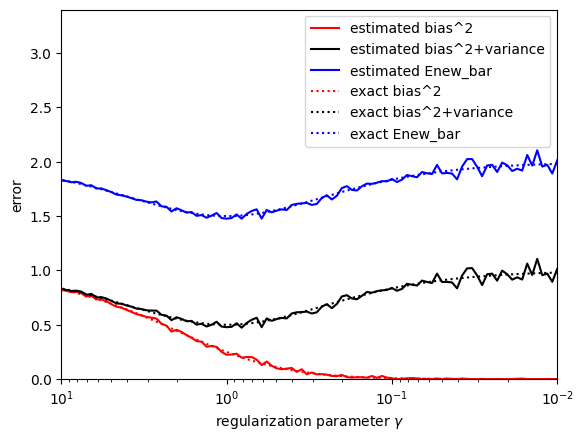

In [30]:
plt.semilogx(ri,bias2,'r',label='estimated bias^2')
plt.semilogx(ri,var+bias2,'k',label='estimated bias^2+variance')
plt.semilogx(ri,enew_bar,'b',label='estimated Enew_bar')
plt.semilogx(ri,(ri/(1+ri))**2,':r',label='exact bias^2')
plt.semilogx(ri,(ri/(1+ri))**2+(1/(1+ri))**2,':k',label='exact bias^2+variance')
plt.semilogx(ri,(ri/(1+ri))**2+(1/(1+ri))**2 + sigma2,':b',label='exact Enew_bar')
plt.axis([ri[-1],ri[0],0,3.4])
plt.xlabel('regularization parameter $\gamma$')
plt.ylabel('error')
plt.legend()
plt.show()

## 6.4 Implementing problem 5.5

Design an experiment (similarly to 6.3) where you numerically confirm the results from problem 5.5.

In [31]:
# number of Monte Carlo samples (when replacing integrals with sums)
N = 1000
# define true function
def f(x):
 return x**2
# generate training data and estimate beta0
beta = np.zeros((2,N))
for i in range(N):
 x = np.random.uniform(-1,1,size=2)
 y = f(x)
 X = np.column_stack((np.ones(2),x))
 beta[:,i] = np.linalg.solve(X,y)
# define g
def g(x_star):
 return np.mean(beta[0,:]) + x_star*np.mean(beta[1,:])
# estimate the squared bias
x_star = np.random.uniform(-1,1,size=N)
bias2 = np.mean((g(x_star)-f(x_star))**2)
# estimate the variance
vari = np.zeros(N)
for i in range(N):
 # average over training data (test data fix at point i)
 yhat = beta[0,:] + beta[1,:]*x_star[i]
 vari[i] = np.mean((yhat-g(x_star[i]))**2)
# average over test data
var = np.mean(vari)
# estimate the expected new data error
enew = np.zeros(N)
for i in range(N):
 # average over test data (training data fix)
 y_star = f(x_star)
 yhat = beta[0,i] + beta[1,i]*x_star
 enew[i] = np.mean((yhat-y_star)**2)
enew_bar = np.mean(enew)
print(bias2)
print(var)
print(enew_bar)

0.19701255905686896
0.315091201592767
0.5121037606496359
